In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


In [2]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import fft, fftpack
from random import randrange
import re
import importlib

import h5py
from scipy.ndimage import zoom

# functions for metrics adapted from .py file provided by Efrat
from metrics import calc_NRMSE as nrmse
from metrics import calc_SSIM as ssim

from ulf_recon_fns import ulfl1recon, applyMask, poissonDiscSigpy, find_lamda_mask, find_iter_mask, coil_combine, awgn
import display_fns

import automap_fns #import automapRecon
import unrolling_fns

2024-12-16 14:19:41.911373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 14:19:42.755228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importing Phantom Data

In [3]:
filename = 'data/phantom_data_75_64_25_2.mat'
data = loadmat(filename)

In [4]:
kspGT = np.moveaxis(data['i_kspace_NA256'],3,0)

In [5]:
kspGT = kspGT[0,:,:,:]+1j*kspGT[1,:,:,:]
kspGT = kspGT[np.newaxis,:]

## Scaling data

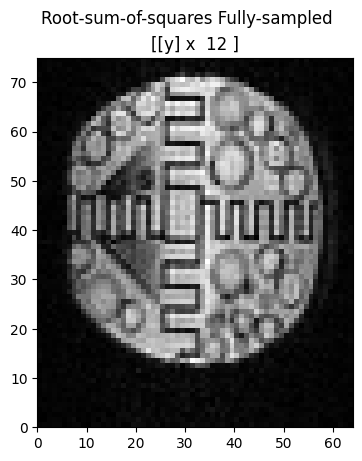

In [6]:
# stock standard recon to get an appropriate scaling factor for the ksp data
img_rss = np.sum(np.abs(sp.ifft(kspGT, axes=(-1, -2, -3)))**2, axis=0)**0.5
volumeGTrss = img_rss

pl.ImagePlot(img_rss, x=1,y=0,title='Root-sum-of-squares Fully-sampled')

# scaling all numbers to sensible values from the beginning
scale_factor = np.percentile(abs(volumeGTrss),95) 
kspGTscaled = kspGT/scale_factor

yshift = -2
kspGTscaled = np.roll(kspGTscaled,(0,yshift,0),axis=(1,2,3))

#kspNA32scaled = kspGTscaled

kspNA32scaled = np.moveaxis(data['i_kspace_NA32'],3,0)/scale_factor*8
kspNA32scaled = np.roll(kspNA32scaled,(0,yshift,0),axis=(1,2,3))

kspNA16scaled = np.moveaxis(data['i_kspace_NA16'],3,0)/scale_factor*16
kspNA16scaled = np.roll(kspNA16scaled,(0,yshift,0),axis=(1,2,3))

kspNA8scaled = np.moveaxis(data['i_kspace_NA8'],3,0)/scale_factor*32
kspNA8scaled = np.roll(kspNA8scaled,(0,yshift,0),axis=(1,2,3))

if kspGTscaled.shape[0] == 1:
    mps = np.ones(kspGTscaled.shape,dtype=complex)
else:
    mps = mr.app.EspiritCalib(kspGTscaled, calib_width=20, kernel_width=6, show_pbar=True).run()
    #mps = mr.app.JsenseRecon(kspGTscaled, ksp_calib_width=20, mps_ker_width=6, show_pbar=True).run()
#mps = np.ones(kspGTscaled.shape)
img_fs = sp.ifft(kspGTscaled, axes=(-1, -2, -3))
volumeGTscaled = coil_combine(img_fs,mps)

In [7]:
mask_metrics = np.ma.getmask(np.ma.masked_less(abs(volumeGTscaled),0.15))

volumeGTscaledmasked = np.copy(volumeGTscaled)
volumeGTscaledmasked[mask_metrics]=0

kspTestScaled = kspNA32scaled #kspGTscaled

#optional recentering of k-space to correct phase map
delta_x = 0
delta_y = 0
delta_z = 0
kspTestScaled = np.roll(kspTestScaled,(delta_x,delta_y,delta_z),axis=(1,2,3)) 

## Input data

In [8]:
#kspInput = kspGTscaled

#kspInput = kspNA32scaled
kspInput = kspNA16scaled
kspInput = kspInput[0,:,:,:]+1j*kspInput[1,:,:,:]
kspInput = kspInput[np.newaxis,:]
NAstr = ' '


## R=2 Calcs

In [9]:
R = 2 # acceleration factor
calib_size = 10

loss_fn = 'mse'
#loss_fn = 'perceptual'


In [10]:
if R==2:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R2.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_real_noise_bkgd_20240318/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r2_imag_noise_bkgd_20240318/checkpoint/model.keras'
    
elif R==4:
    unroll_model_pth = 'trained_models/Unrolling/Unroll_mse_R4.pth'
    model_real_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_real_noise_bkgd_20240328/checkpoint/model.keras' #fast mri model
    model_imag_dir = 'trained_models/AUTOMAP/train_25x75_fmri-hcp_r4_imag_noise_bkgd_20240328/checkpoint/model.keras'


### Poisson Disc Mask

In [11]:

# defining PD mask
imSize = np.array(img_rss.shape)

in_seed = 0#randrange(100)
if R==1:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)  
elif R==2:
  mask = poissonDiscSigpy(imSize,R, in_seed,calib_size)
elif R==4:
  mask = poissonDiscSigpy(imSize,R+0.5, in_seed,calib_size)  
mask.shape

1/np.mean(abs(mask)) #true R value


1.9389865563598758

## Masking and Reconstructing Data

In [12]:
uskspace = applyMask(kspInput,mask)

In [13]:
no_masks = 1
lamda_opt=0.05
iter_opt = 25
lamda_opt = find_lamda_mask(uskspace, volumeGTscaled, mps,calib_size, show_plot=False)
iter_opt = find_iter_mask(uskspace,volumeGTscaled, lamda_opt, mps, show_plot=False)
volcsrecon = ulfl1recon(uskspace,mask,lamda_opt,iter_opt,mps)

volifftrecon_mc = sp.ifft(uskspace,axes=[1,2,3])
volifftrecon = coil_combine(volifftrecon_mc,mps)# np.sqrt(np.sum(np.abs(volifftrecon_mc)**2,axis=0)).reshape(imSize)

/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')
/home/david/repos/Low_Field_MRI_Recon/metrics.py:39: RuntimeWarning: invalid value encountered in cast
  im2_mag_uint8 = (I_pred * 255 / np.max(I_pred)).astype('uint8')


In [14]:
uskspace = np.roll(kspInput,(0,0,0),axis=(1,2,3)) 
uskspace = applyMask(uskspace,mask)

amap_scale = 1#0.01
unroll_scale = 1
volunrollrecon = unrolling_fns.unrollingRecon(uskspace*unroll_scale,mask,unroll_model_pth)/unroll_scale
volamaprecon, volamaprecon_mc = automap_fns.automapRecon(uskspace*amap_scale,mps,model_real_dir,model_imag_dir)
volamaprecon = volamaprecon/amap_scale
volamaprecon_mc = volamaprecon_mc/amap_scale

(1, 75, 64, 25)


2024-12-16 14:21:50.045802: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-16 14:21:50.045858: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: autobeast
2024-12-16 14:21:50.045864: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: autobeast
2024-12-16 14:21:50.045932: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.14
2024-12-16 14:21:50.045955: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.14
2024-12-16 14:21:50.045960: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.14


## NEX 256 as reference

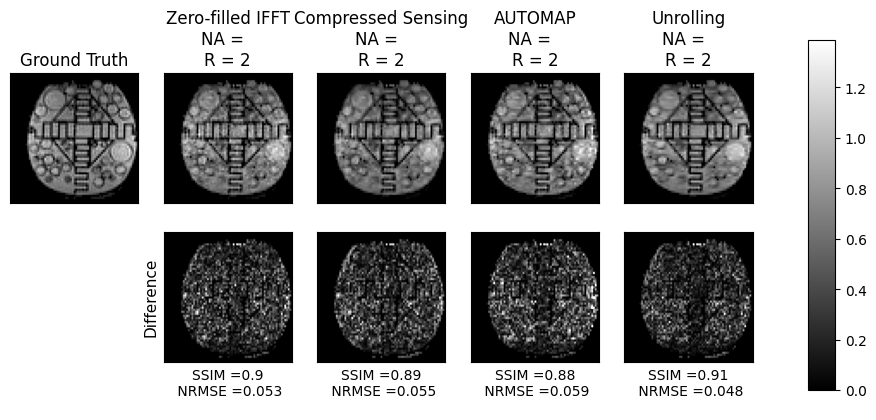

Difference Maps are scaled by  3


In [15]:
volumeGTscaledmasked = np.copy(volumeGTscaled)
volumeGTscaledmasked[mask_metrics]=0
vol1 = np.copy(volifftrecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nNA = '+NAstr+'\nR = '+str(R)
vol2 = np.copy(volcsrecon)
vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nNA = '+NAstr+'\nR = '+str(R)
vol3 = np.copy(volamaprecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nNA = '+NAstr+'\nR = '+str(R)
vol4 = np.copy(volunrollrecon)
vol4[mask_metrics]=0
vol4title = 'Unrolling\nNA = '+NAstr+'\nR = '+str(R)

vol1_R2 = vol1
vol2_R2 = vol2
vol3_R2 = vol3
vol4_R2 = vol4

slc=17
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

#fig_comp.savefig('export_figs/phantom_masked.pdf')

## NEX 16 as reference

In [16]:
volumeGTscaledmasked = np.copy(sp.ifft(kspInput[0,:,:,:],axes=[1,2,3]))

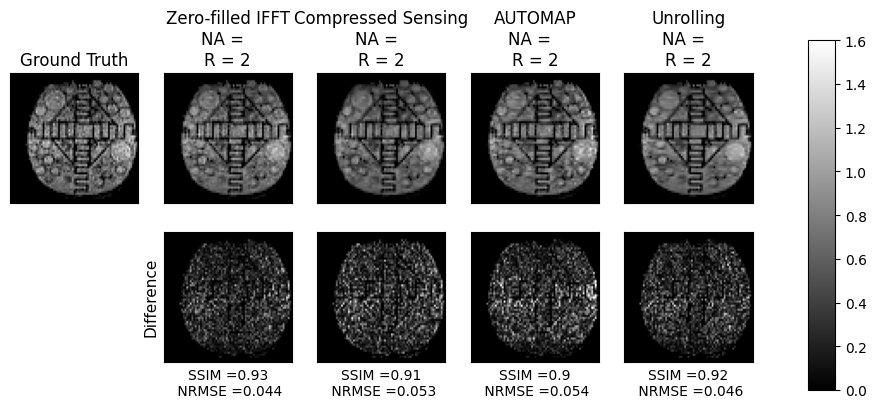

Difference Maps are scaled by  3


In [17]:
volumeGTscaledmasked = np.copy(volumeGTscaledmasked)
volumeGTscaledmasked[mask_metrics]=0
vol1 = np.copy(volifftrecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol1[mask_metrics]=0
vol1title = 'Zero-filled IFFT\nNA = '+NAstr+'\nR = '+str(R)
vol2 = np.copy(volcsrecon)
vol2[mask_metrics]=0
vol2title = 'Compressed Sensing\nNA = '+NAstr+'\nR = '+str(R)
vol3 = np.copy(volamaprecon)#np.ma.masked_array(volifftrecon, mask = mask_metrics)
vol3[mask_metrics]=0
vol3title = 'AUTOMAP\nNA = '+NAstr+'\nR = '+str(R)
vol4 = np.copy(volunrollrecon)
vol4[mask_metrics]=0
vol4title = 'Unrolling\nNA = '+NAstr+'\nR = '+str(R)

vol1_R2 = vol1
vol2_R2 = vol2
vol3_R2 = vol3
vol4_R2 = vol4

slc=17
fig_comp = display_fns.compareFourPlot(volumeGTscaledmasked,vol1,vol1title,vol2,vol2title,vol3,vol3title,vol4,vol4title,slc, scale_err=3)

#fig_comp.savefig('export_figs/phantom_masked.pdf')